In [27]:
import pandas as pd
import os
import numpy as np

In [28]:
# read data

data = pd.read_csv("data.csv", usecols=['message_clean'])
data.head()

,message_clean
0,aethero support trouble find clear documentati...
1,experience critical issue user permission prod...
2,aethero support experience urgent issue deploy...
3,aethero support team write improvement api dev...
4,aethero support quick question api monitor das...


In [29]:
# tokenize data

docs = data["message_clean"].tolist()

In [30]:
# create bigram tokenizer
from sklearn.feature_extraction.text import CountVectorizer

bigram_vectorizer = CountVectorizer(
    ngram_range=(2, 2),    # Only bigrams
    max_features=1000      # Top 1000 bigrams by frequency
)

In [31]:
# set model to train on tokenized data for bigrams in random state
from turftopic import FASTopic

topic_size  = 10
model = FASTopic(n_components = topic_size, 
                 vectorizer = bigram_vectorizer,
                 random_state = 32).fit(docs)

Output()

[19:29:03] Documents encoded.                                                                       ]8;id=314557;file://c:\Users\xpetr\.conda\envs\Turftopic\Lib\site-packages\turftopic\models\fastopic.py\fastopic.py]8;;\:]8;id=135864;file://c:\Users\xpetr\.conda\envs\Turftopic\Lib\site-packages\turftopic\models\fastopic.py#157\157]8;;\

           Term extraction done.                                                                    ]8;id=866351;file://c:\Users\xpetr\.conda\envs\Turftopic\Lib\site-packages\turftopic\models\fastopic.py\fastopic.py]8;;\:]8;id=278016;file://c:\Users\xpetr\.conda\envs\Turftopic\Lib\site-packages\turftopic\models\fastopic.py#161\161]8;;\

[19:29:08] Model fitting done.                                                                      ]8;id=870673;file://c:\Users\xpetr\.conda\envs\Turftopic\Lib\site-packages\turftopic\models\fastopic.py\fastopic.py]8;;\:]8;id=317722;file://c:\Users\xpetr\.conda\envs\Turftopic\Lib\site-packages\turftopic\models\fastopic.py#164\164]8;;\

In [32]:
topics_df = model.topics_df()

# First, split and explode
topics_df.columns = ['topic_id', 'topic_words']
topics_df['topic_word'] = topics_df['topic_words'].str.split(',')
topics_df = topics_df.explode('topic_word')

# Add a rank for each word within a topic (optional, for row order)
topics_df['word_rank'] = topics_df.groupby('topic_id').cumcount() + 1

# Pivot to wide format: columns are (topic_id, topic_name), rows are word_rank, values are topic_word
wide = topics_df.pivot(index='word_rank', columns=['topic_id'], values='topic_word')
wide

topic_id,0,1,2,3,4,5,6,7,8,9
word_rank,,,,,,,,,,
1,spike api,scale cloud,issue mercury,experience intermittent,access resource,api development,deploy mercury,work project,estimate time,role iam
2,dashboard show,improvement api,error mercury,peak hour,issue iam,dear aethero,deployment process,project mercury,time resolution,role inheritance
3,monitor dashboard,average response,compiler error,support experience,iam role,sincerely isabella,aetheros cloud,integrate mercury,host cloud,user role
4,api monitoring,management service,face critical,response times,unable access,team write,aethero cloud,trouble find,business operation,achieve this
5,api monitor,improvement cloud,unexpected token,api gateway,aetheros iam,support evaluate,mercury application,language api,production api,iam service
6,api performance,resource usage,urgent assistance,api develop,disruption operation,development service,issue deploy,clear documentation,impact business,service specifically
7,monitor platform,however suggestion,priority issue,intermittent latency,issue aetheros,async await,experience difficulty,support work,major outage,developer role
8,rely heavily,difficulty scale,advise proceed,urgently provide,urgent issue,support write,cloud environment,find clear,asap advise,access control
9,monitoring service,service month,language compiler,provide update,experience critical,incredibly beneficial,encounter error,error handling,step asap,specific role


In [33]:
# fit model to data
topic_data = model.prepare_topic_data(docs)

# create document-term matrix
dtm = topic_data.document_topic_matrix

# assign topics to each document
topic_assignments = np.argmax(dtm, axis=1)
topics = topic_assignments.tolist()

# Merge topic assignments with data on index
data_with_topics = data.copy()
data_with_topics['topic_assignment'] = topic_assignments

In [ ]:
# use the Namer to label topics
from turftopic.namers import OpenAITopicNamer

os.environ["OPENAI_API_KEY"] = ""    #add your OpenAI API key

namer = OpenAITopicNamer("gpt-4o-mini")
model.rename_topics(namer)

Output()

In [ ]:
# create a dataframe with labelled topics
topics_df = model.topics_df()
topics_df.columns = ['topic_id', 'topic_name', 'topic_words']

# First, split and explode
topics_df['topic_word'] = topics_df['topic_words'].str.split(',')
topics_df = topics_df.explode('topic_word')
topics_df['topic_word'] = topics_df['topic_word'].str.strip()

# Add a rank for each word within a topic
topics_df['word_rank'] = topics_df.groupby('topic_id').cumcount() + 1

# Pivot to wide format
wide = topics_df.pivot(index='word_rank', columns=['topic_id', 'topic_name'], values='topic_word')

In [36]:
wide

topic_id,0,1,2,3,4,5,6,7,8,9
topic_name,API Performance Monitoring,Cloud Resource Optimization Management,Mercury Compiler Error Troubleshooting,Optimizing API Performance and Support Experiences,IAM Access Issue,Collaborative API Development Services,Mercury Deployment Challenges in Aetheros Cloud,Project Mercury Integration and Support,Business Continuity and Time Management in Cloud Operations,IAM Role Management
word_rank,,,,,,,,,,
1,spike api,scale cloud,issue mercury,experience intermittent,access resource,api development,deploy mercury,work project,estimate time,role iam
2,dashboard show,improvement api,error mercury,peak hour,issue iam,dear aethero,deployment process,project mercury,time resolution,role inheritance
3,monitor dashboard,average response,compiler error,support experience,iam role,sincerely isabella,aetheros cloud,integrate mercury,host cloud,user role
4,api monitoring,management service,face critical,response times,unable access,team write,aethero cloud,trouble find,business operation,achieve this
5,api monitor,improvement cloud,unexpected token,api gateway,aetheros iam,support evaluate,mercury application,language api,production api,iam service
6,api performance,resource usage,urgent assistance,api develop,disruption operation,development service,issue deploy,clear documentation,impact business,service specifically
7,monitor platform,however suggestion,priority issue,intermittent latency,issue aetheros,async await,experience difficulty,support work,major outage,developer role
8,rely heavily,difficulty scale,advise proceed,urgently provide,urgent issue,support write,cloud environment,find clear,asap advise,access control


In [37]:
# Remove MultiIndex: flatten columns to single level by joining with underscore
wide_flat = wide.copy()
if isinstance(wide_flat.columns, pd.MultiIndex):
    wide_flat.columns = [': '.join([str(i) for i in col if i != '']) for col in wide_flat.columns]

In [38]:
cleaned_column_list = []

for col in wide_flat.columns.tolist():
    # Remove numbers and colons from each column name
    cleaned_col = ''.join(char for char in str(col) if not char.isdigit() and char != ':')
    cleaned_col = cleaned_col.strip()  # Remove extra whitespace
    if cleaned_col:  # Only add non-empty strings
        cleaned_column_list.append(cleaned_col)

In [39]:
# Remove MultiIndex: flatten columns to single level by joining with underscore
wide_flat = wide.copy()
if isinstance(wide_flat.columns, pd.MultiIndex):
    wide_flat.columns = [': '.join([str(i) for i in col if i != '']) for col in wide_flat.columns]

# # Now keep only columns where the name starts with a digit
wide_numeric = wide_flat[[col for col in wide_flat.columns if str(col)[0].isdigit()]]

# Create list of tuples following the structure (topic_id, topic_name, topic_words)
topics_list = []

for column in wide_numeric.columns:
    # Extract topic_id from column name (first part before colon)
    topic_id = int(column.split(':')[0])
    
    # Extract topic_name from column name (part after colon)
    topic_name = column.split(':', 1)[1].strip()
    
    # Get all words for this topic (non-null values in this column)
    words = wide_numeric[column].dropna().tolist()
    topic_words = ', '.join(words)
    
    # Create tuple and add to list
    topics_list.append((topic_id, topic_name, topic_words))

# Sort by topic_id to ensure proper order
topics_list.sort(key=lambda x: x[0])

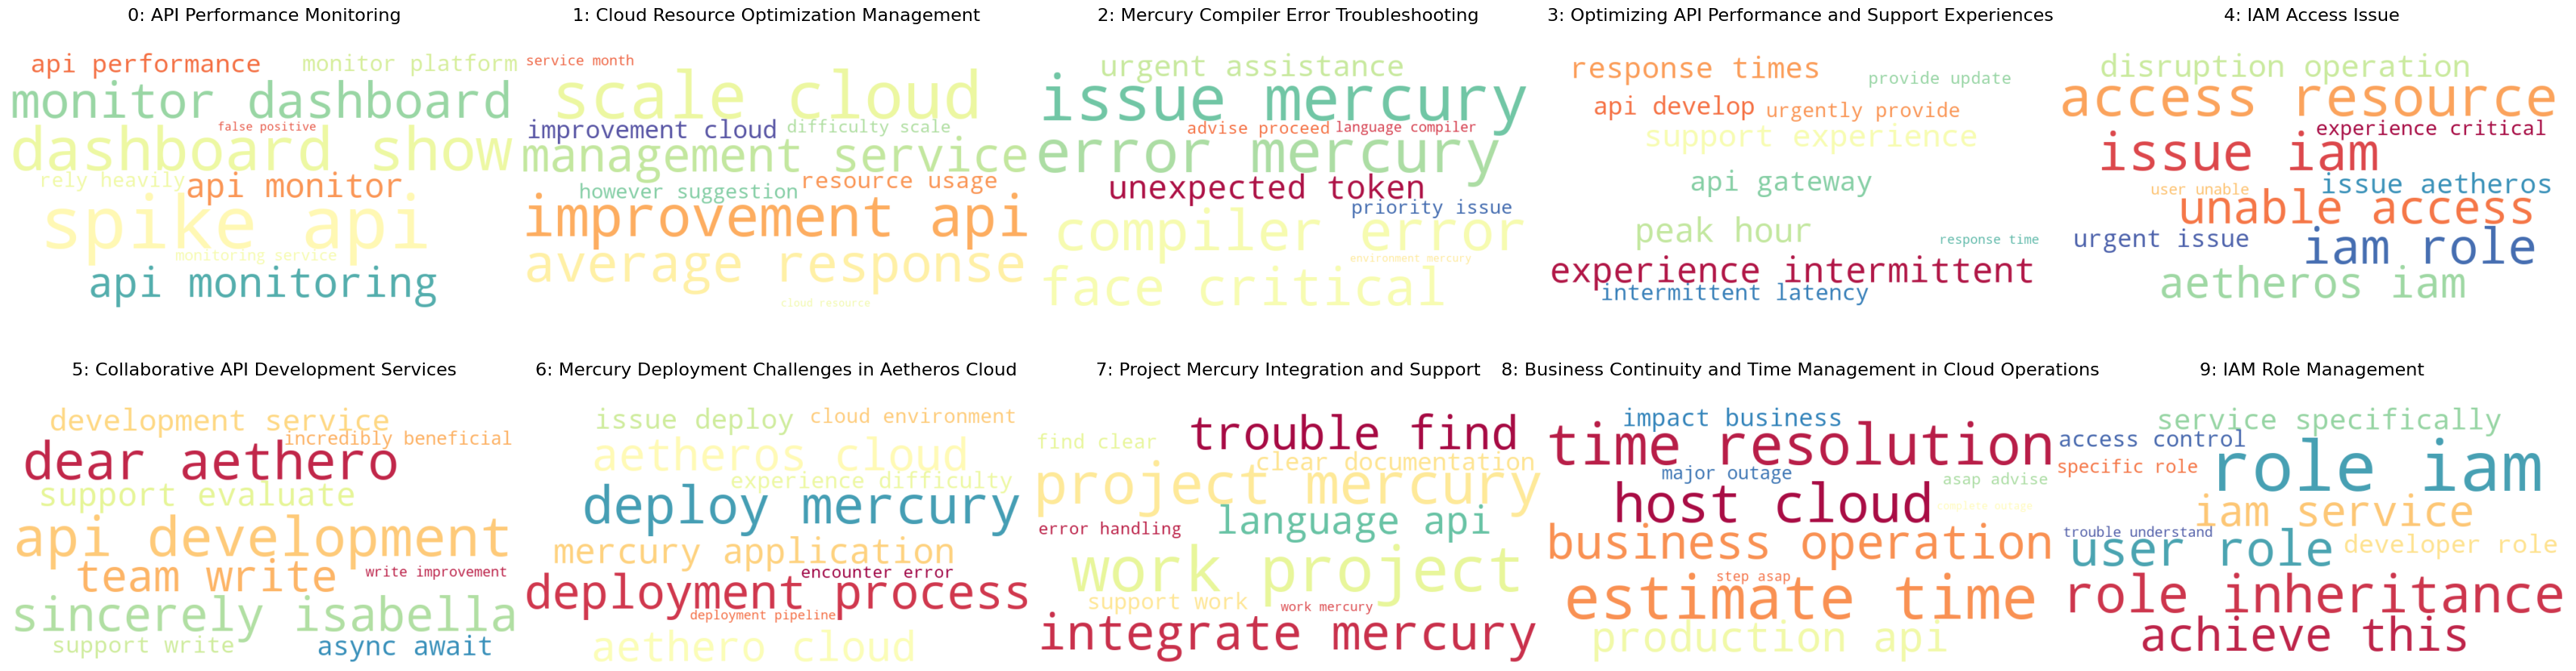

In [40]:
# visualize the topics in bigram word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(32, 12))
axes = axes.flatten()

for idx, (topic_id, topic_name, keywords) in enumerate(topics_list):
    raw_tokens = keywords.split(", ")
    tokens = [token.strip().replace("ˍ", " ") for token in raw_tokens]
    freqs = {token: len(tokens) - i for i, token in enumerate(tokens)}

    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          colormap='Spectral', collocations=False).generate_from_frequencies(freqs)

    axes[idx].imshow(wordcloud, interpolation='bilinear')
    # Shift title above the axes, normal weight
    axes[idx].set_title(f"{topic_id}: {topic_name}", fontsize=16, weight='normal', y=1.1)
    axes[idx].axis("off")

# Remove extra subplot axes (if any)
for j in range(len(topics_list), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=-0.4)
plt.savefig("FAST_10_wordcloud.png", dpi=100, bbox_inches='tight')
plt.show()